# This Bone does not Exist

This notebook demonstrates generating medical data with a limited dataset ~1k images, and 10 bucks for Colab Pro.

* Based on the work of: [Jeff Heaton](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_train_gan.ipynb)
* Nvidia Algorithm: [StyleGan2-Ada](https://github.com/NVlabs/stylegan2-ada-pytorch)

## Link colab to google drive

You will mount the drive at the following location.

```
/content/drive/MyDrive/data
```

In [1]:

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


## Folder Structure

You will store your training data and trained neural networks to GDRIVE. For GANs, I lay out my GDRIVE like this:

* ./data/gan/images - RAW images I wish to train on.
* ./data/gan/datasets - Actual training datasets that I convert from the raw images.
* ./data/gan/experiments - The output from StyleGAN2, my image previews, and saved network snapshots.

## Data

You will want to grab the [Kaggle Chest XRay Dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) The license is pretty generous so we can use it for this tutorial. You will want to download the images and place it in this folder `./data/gan/images `

## Dependencies

In [2]:
!pip -q install torch==1.8.1 torchvision==0.9.1
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip -q install ninja

     |████████████████████████████████| 804.1 MB 2.5 kB/s 
     |████████████████████████████████| 17.4 MB 24.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.8.1 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.8.1 which is incompatible.
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 1.10 MiB/s, done.
Resolving deltas: 100% (57/57), done.
     |████████████████████████████████| 108 kB 4.3 MB/s 



## Convert Your Images

Stylegan is pretty picky about the image format. You will want to reformat them to be the same as our pretrained network. In this case, we are going to use `ffhq256` which is RGB 256x256.

In [4]:
import os
from PIL import Image

if False:
  my_path = "/content/drive/MyDrive/data/gan/images/chest_xray"
  dest_path = "/content/drive/MyDrive/data/gan/images/chest_xray_resized"

  for file in os.listdir(my_path):
      f_img = my_path+"/"+file
      d_img = dest_path+"/"+file
      img = Image.open(f_img).resize((256,256)).convert('RGB')
      img.save(d_img)

In [ ]:
CMD = "python /content/stylegan2-ada-pytorch/dataset_tool.py "\
  "--source /content/drive/MyDrive/data/gan/images/chest_xray_resized "\
  "--dest /content/drive/MyDrive/data/gan/dataset/chest_xray" \

!{CMD}

100% 1545/1545 [00:16<00:00, 93.06it/s]


You can use the following command to clear out the newly created dataset.  If something goes wrong and you need to clean up your images and rerun the above command, you should delete your partially completed dataset directory.

In [ ]:
#!rm -R /content/drive/MyDrive/data/gan/dataset/chest_xray/*

## Hack

The following line needs to be here. Bad things happen if it is not.

In [ ]:
%tensorflow_version 1.x

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


## Training

We are going to train using the `train.py` command. The following explains the arguments


*   snap controls how often snapshots are grabbed.
*   outdir is where the sample output generated images are placed
*   data is your training data
*   resume is where you are resuming from, in our case a pretrained model.
*   cfg are hyper params configurations. 

More info is available on the nvidia github page.

In [ ]:
import os

# Modify these to suit your needs
EXPERIMENTS = "/content/drive/MyDrive/data/gan/experiments"
DATA = "/content/drive/MyDrive/data/gan/dataset/chest_xray"
SNAP = 10

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan2-ada-pytorch/train.py "\
  f"--snap {SNAP} --outdir {EXPERIMENTS} --data {DATA} --resume=ffhq256 --cfg=paper256"
  # f"--snap {SNAP} --outdir {EXPERIMENTS} --data {DATA}"
!{cmd}


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/data/gan/dataset/chest_xray",
    "use_labels": false,
    "max_size": 1545,
    "xflip": false,
    "resolution": 256
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 8
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 8
    },
    "channel_base": 16

## Analyzing

If you look above, there were 8 iterations where the fid score starts to drop and then goes back up. You can think of the fid as a tool to guage how your gan is training. Now you have to keep in mind the fid will only take you so far. With GANS, you need to look at the output yourself. See the blog to review the image outputs.





## Generating

This is generating images

In [ ]:
# Generate uncurated MetFaces images with truncation (Fig.12 upper left)
RESULTS = "/content/drive/MyDrive/data/gan/results"
NETWORK = "/content/drive/MyDrive/data/gan/experiments/00004-chest_xray-paper256-resumeffhq256/network-snapshot-000201.pkl"

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan2-ada-pytorch/generate.py "\
  f"--outdir {RESULTS} --trunc=0.7 --seeds=600-700 --network={NETWORK}"
!{cmd}    

Loading networks from "/content/drive/MyDrive/data/gan/experiments/00004-chest_xray-paper256-resumeffhq256/network-snapshot-000201.pkl"...
Generating image for seed 600 (0/101) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 601 (1/101) ...
Generating image for seed 602 (2/101) ...
Generating image for seed 603 (3/101) ...
Generating image for seed 604 (4/101) ...
Generating image for seed 605 (5/101) ...
Generating image for seed 606 (6/101) ...
Generating image for seed 607 (7/101) ...
Generating image for seed 608 (8/101) ...
Generating image for seed 609 (9/101) ...
Generating image for seed 610 (10/101) ...
Generating image for seed 611 (11/101) ...
Generating image for seed 612 (12/101) ...
Generating image for seed 613 (13/101) ...
Generating image for seed 614 (14/101) ...
Generating image for seed 615 (15/101) ...
Generating image for seed 616 (16/101) ...
Generating image for seed 617 (17

## View Results

Let's take a look at our results

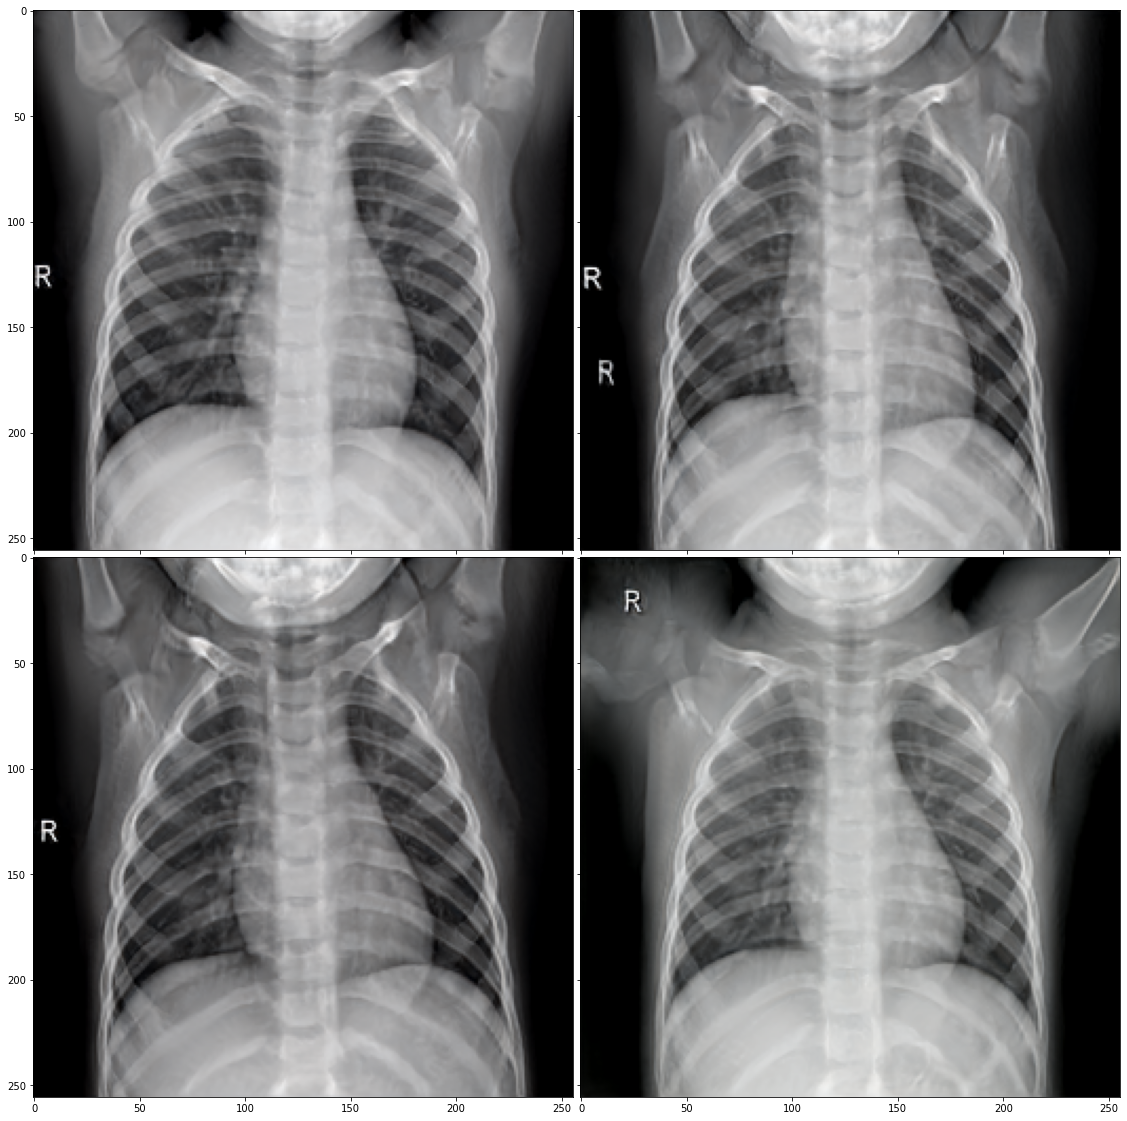

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
image_paths = os.listdir(RESULTS)[:4]
img_arr = []

for image_path in image_paths:
    img_arr.append(np.asarray(Image.open(f"{RESULTS}/{image_path}")))

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)